<a href="https://colab.research.google.com/github/rothn/P1P2Adapter/blob/main/brazil_cv_evals_for_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Isoscape Evals

Notebook Purpose: Eval isoscape generation methods for our paper

Isoscape Task: Find the mean/variance of O18 ratios (as well as N15 and C13 in the future) at a particular lat/lon across Brazil.

# Setup

## Fetch Dependencies

In [2]:
!pip install rasterio fiona pykrige

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.6/979.6 kB 33.1 MB/s eta 0:00:00


## Import libraries required

In [3]:
import importlib
from datetime import datetime
import sys
import os

In [4]:
!if [ ! -d "/content/ddf_common_stub" ] ; then git clone -b test https://github.com/tnc-br/ddf_common_stub.git; fi
sys.path.append("/content/ddf_common_stub/")
import ddfimport
ddfimport.ddf_import_common()
#ddfimport.ddf_import_common("nicholas@rothemail.net", branch_name="cv-fixes")

Cloning into 'ddf_common_stub'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 18 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 7.36 KiB | 1.23 MiB/s, done.
Resolving deltas: 100% (7/7), done.
executing checkout_branch ...
b''
main branch checked out as readonly. You may now use ddf_common imports


In [5]:
import train_variational_inference_model as tvim
import raster
import eeddf
import dataset
import model
import fiona
import rasterio.mask
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount(raster.GDRIVE_BASE)

# Leave test_environment=True. Experiments must be done in test.
eeddf.initialize_ddf(test_environment=True)

Mounted at /content/gdrive


In [6]:
# Patch https://github.com/tnc-br/ddf_common/issues/72 here
import evaluation
importlib.reload(evaluation)
importlib.reload(tvim)

<module 'train_variational_inference_model' from '/tmp/ddf_common/train_variational_inference_model.py'>

# Data configuration

In [28]:
!cat {raster.GDRIVE_BASE + raster.SAMPLE_DATA_BASE + 'canonical/12_16_filtered_train_random_grouped_no_nans.csv'} <(echo -e '\n') <(tail -n+2 {raster.GDRIVE_BASE + raster.SAMPLE_DATA_BASE + 'canonical/12_16_filtered_validation_random_grouped.csv'}) > /tmp/tmp.txt
!cat /tmp/tmp.txt <(tail -n+2 {raster.GDRIVE_BASE + raster.SAMPLE_DATA_BASE + 'canonical/12_16_filtered_test_random_grouped.csv'}) > {raster.GDRIVE_BASE + raster.SAMPLE_DATA_BASE + 'canonical/12_16_filtered_train_random_grouped_no_nans_recombined.csv'}

In [29]:
!cat {raster.GDRIVE_BASE + raster.SAMPLE_DATA_BASE + 'canonical/12_16_filtered_train_random_grouped_no_nans_recombined.csv'}

,Code,lat,long,d13C_foliar,d15N_foliar,d15N_soil,VPD,RH,PET,DEM,PA,Mean Annual Temperature,Mean Annual Precipitation,Iso_Oxi_Stack_mean_TERZER,brisoscape_mean_ISORIX,d13C_cel_mean,d13C_cel_var,ordinary_kriging_linear_d18O_predicted_mean,ordinary_kriging_linear_d18O_predicted_variance,isoscape_fullmodel_d18O_prec_REGRESSION,d18O_cel_count,d18O_cel_mean,d18O_cel_variance
0,mad0,-0.121,-67.013,-29.90248299,1.110507131,6.619165421,0.58917,0.83284,91.16666,101,1000.8927,26.20833,2830,-3.91908,-3.919083913,-28.60016632,0.0446169277,24.99242038,0.7110013855,-4.692925135,5,23.40526,0.1482754599
1,mad1,-3.995544837,-57.58927257,-28.99231529,4.894455433,9.003260612,0.85167,0.77358,99.99167,61,1005.67358,27.16667,2273,-3.78967,-3.789665222,-27.92172496,0.03372090807,26.09742306,0.7143894975,-3.730410576,5,26.748,0.53267
2,mad10,-0.121229892,-67.01310259,-29.90248299,1.110507131,6.619165421,0.58917,0.83284,91.16666,101,1000.8927,26.20833,2830,-3.91908,-3.919083913,-28.60016632,0.0446169277,24.9924

In [30]:
import evaluation
importlib.reload(evaluation)

<module 'evaluation' from '/tmp/ddf_common/evaluation.py'>

In [31]:
raster.GDRIVE_BASE + raster.SAMPLE_DATA_BASE

'/content/gdrive/MyDrive/amazon_rainforest_files/amazon_sample_data/'

In [32]:
# REQUIREMENTS:

# 1) Column names must match features_to_standardize, features_to_passthrough
# 2) Label columns in particular must match var_label and mean_label.
#
# If you used the data ingestion notebook (ingestion.ipynb) then this
# should be set up for you already.

# TRAINING FILE PARAMS
DATABASE_DIR = raster.GDRIVE_BASE + raster.SAMPLE_DATA_BASE
TRAINING_SET_FILE = 'canonical/12_16_filtered_train_random_grouped_no_nans_recombined.csv' #@param
VALIDATION_SET_FILE = '' #@param
TEST_SET_FILE = '' #@param

# EVAL FILE PARAMS
EVAL_DATASET = '' #@param
#ORIGINAL_DATASET = 'canonical/2023_07_27_Results_google_utf8_latlonadded.csv' #@param
ORIGINAL_DATASET = 'canonical/12_16_ungrouped.csv' #@param


fileset = {
    'TRAIN' : os.path.join(DATABASE_DIR, TRAINING_SET_FILE),
#    'TEST' : os.path.join(DATABASE_DIR, VALIDATION_SET_FILE),
#    'VALIDATION' : os.path.join(DATABASE_DIR, TEST_SET_FILE),
#    'EVAL' : os.path.join(DATABASE_DIR, EVAL_DATASET),
    'ORIGINAL' : os.path.join(DATABASE_DIR, ORIGINAL_DATASET)
}

def prepare_dataset(params: tvim.VIModelTrainingParams, files: dict) -> dataset.ScaledPartitions:
  # Prepared columns not in the original input-- these are engineered features
  # that we believe include strong signals, stored as geotiffs
  potentially_extra_columns = [
      "brisoscape_mean_ISORIX",
      "d13C_cel_mean",
      "d13C_cel_var",
      "ordinary_kriging_linear_d18O_predicted_mean",
      "ordinary_kriging_linear_d18O_predicted_variance",
  ]

  #Load the geotiff it the params request it.
  extra_columns_from_geotiffs = {}
  for feature in params.features_to_passthrough + params.features_to_standardize:
      if feature in potentially_extra_columns:
          extra_columns_from_geotiffs[feature] = raster.column_name_to_geotiff_fn[feature]()

  return dataset.load_and_scale(
      files,
      params.mean_label,
      params.var_label,
      params.features_to_passthrough,
      [],
      params.features_to_standardize,
      extra_columns_from_geotiffs)

with fiona.open('zip:///content/gdrive/MyDrive/amazon_rainforest_files/shapefiles/bra_adm_ibge_2020_shp.zip') as shp:
  BRAZIL_SHP_MASK = [feature["geometry"] for feature in shp]

with fiona.open('zip:///content/gdrive/MyDrive/amazon_rainforest_files/shapefiles/Amazon Biome.zip/data/commondata/data0') as shp:
  AMAZON_SHP_MASK = [feature["geometry"] for feature in shp]

# Load these lazily later from the first generated isoscapes

def display_brazil(band_index: int):
  with rasterio.open(ISOSCAPE_SAVE_LOCATION) as src:
    raster_data = src.read(band_index+1)  # Read the first band
    out_image, out_transform = rasterio.mask.mask(src, BRAZIL_SHP_MASK, crop=False)
    out_meta = src.meta
    brazil_np_mask = np.logical_not(out_image.astype(bool))

  geotiff = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=band_index)
  fig = plt.figure( figsize=(8,8) )
  extent = raster.get_extent(geotiff.gdal_dataset).to_matplotlib()
  ax = fig.add_subplot()
  to_show = np.ma.MaskedArray(geotiff.yearly_masked_image.data, brazil_np_mask[0])
  im = fig.axes[0].imshow(to_show, interpolation='none', aspect='auto', extent = extent)
  plt.colorbar(im)

def display_amazon(band_index: int):
  with rasterio.open(ISOSCAPE_SAVE_LOCATION) as src:
    raster_data = src.read(band_index+1)  # Read the first band
    out_image, out_transform = rasterio.mask.mask(src, AMAZON_SHP_MASK, crop=False)
    out_meta = src.meta
    amazon_np_mask = np.logical_not(out_image.astype(bool))

  geotiff = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=band_index)
  fig = plt.figure( figsize=(8,8) )
  extent = raster.get_extent(geotiff.gdal_dataset).to_matplotlib()
  ax = fig.add_subplot()
  to_show = np.ma.MaskedArray(geotiff.yearly_masked_image.data, amazon_np_mask[0])
  im = fig.axes[0].imshow(to_show, interpolation='none', aspect='auto', extent = extent)
  plt.colorbar(im)

# Non-VI Models

## Ordinary Kriging

Based on https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/examples/00_ordinary.html

In [33]:
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [34]:
params = tvim.VIModelTrainingParams(
    training_id = "test-okrige-2025-02-28-1", #@param
    num_epochs = -1,
    num_layers = -1,
    num_nodes_per_layer = -1,
    training_batch_size = -1,
    learning_rate = -1,
    mean_label = "d18O_cel_mean", #@param
    var_label = "d18O_cel_variance", #@param
    early_stopping_patience = -1,
    min_steps = -1,
    double_sided_kl = False,
    kl_num_samples_from_pred_dist = 1,
    dropout_rate = -1,
    activation_func = "",
    features_to_standardize = ['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA', 'Mean Annual Temperature', 'Mean Annual Precipitation', 'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION', 'brisoscape_mean_ISORIX', 'd13C_cel_mean', 'd13C_cel_var', 'ordinary_kriging_linear_d18O_predicted_mean', 'ordinary_kriging_linear_d18O_predicted_variance'], #@param
    features_to_passthrough = [], #@param
    resolution_x = 1024, #@param
    resolution_y = 1024, #@param
    tags = ["author:npr", "ordinary_kriging", "all_standardized", "gaussian_variogram", "cv", "rev1"], #@param
    n_cv_folds=5, #@param
)
eval_params = tvim.VIModelEvalParams(
    samples_per_location = 5, #@param
    precision_target = 0.95, #@param
    recall_target = None, #@param
    start_max_fraud_radius= 6, #@param
    end_max_fraud_radius = 3000, #@param
    radius_pace = 100, #@param
    trusted_buffer_radius = 5, #@param
    elements_to_eval = ['d18O_cel'], #@param
)


MODEL_SAVE_LOCATION = os.path.join(raster.GDRIVE_BASE, raster.MODEL_BASE, params.training_id + ".keras")
ISOSCAPE_SAVE_LOCATION = raster.get_raster_path(params.training_id+".tiff")


In [35]:
data = prepare_dataset(params, fileset)

In [ ]:
import pandas as pd
import numpy as np
import raster
import generate_isoscape
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from ast import Pass
from sklearn import metrics

raw_train = pd.read_csv(fileset['TRAIN'])

In [ ]:
class OrdinaryKrigingModel:
  def __init__(self, data):
    self.ok = None
    self.min_long = min(data.train.X['long'])
    self.max_long = max(data.train.X['long'])
    self.min_lat = min(data.train.X['lat'])
    self.max_lat = max(data.train.X['lat'])

  def fit(self, X_train, Y_train, validation_data, **kwargs):
    self.ok = OrdinaryKriging(X_train['lat'], X_train['long'], Y_train['d18O_cel_mean'], **kwargs)

  def score(self, X, y):
    predicted = self.predict_on_batch(X)
    return metrics.root_mean_squared_error(y, predicted)

  def predict_on_batch(self, X):
    # A DataFrame [means, vars]
    x_coords = []
    y_coords = []
    for _, row in X.iterrows():
      x_coords.append(row['lat'],)
      y_coords.append(row['long'],)
    means, vars = self.ok.execute("points", x_coords, y_coords)
    return np.array([means, vars]).T

  def gen_isoscape(self, params):

    # Predict the isotope values on the range of lattitude and longitude values
    # within the bounds of our VPD geotiff (should be Brazil-shaped), then save
    # for qualitative eval / display
    isoscape_long_values = np.linspace(self.min_long, self.max_long, params.resolution_x)
    isoscape_lat_values = np.linspace(self.min_lat, self.max_lat, params.resolution_y)

    means, variances  = self.ok.execute("grid", isoscape_long_values,
                                    isoscape_lat_values)
    self.ok.print_statistics()

    arbitrary_geotiff = raster.vapor_pressure_deficit_geotiff()
    base_bounds = raster.get_extent(arbitrary_geotiff.gdal_dataset)
    final_bounds = raster.create_bounds_from_res(params.resolution_x, params.resolution_y, base_bounds)

    all_predictions = np.ma.masked_array([means, variances], mask=[np.isnan(means), np.isnan(variances)]) # raster, lat, lon
    all_predictions = np.transpose(all_predictions, axes=[1, 2, 0]) # lat, lon, raster

    generate_isoscape.save_numpy_to_geotiff(final_bounds, all_predictions, ISOSCAPE_SAVE_LOCATION)

cv_outs = model.cross_val_with_best_model(lambda: OrdinaryKrigingModel(data),
                                          lambda m, x, y: m.score(x, y),
                                          data,
                                          n_cv_folds=5,
                                          # Model KW Args
                                          variogram_model='linear')
training_artifacts, final_model, cv_artifacts = cv_outs

Training fold #0 ||| (train_index_start: [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248], val_index_start: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 4

In [ ]:
cv_artifacts

{'mean_rmse': np.float64(1.3704257487921239),
 'var_rmse': np.float64(1.7672576481129485)}

In [ ]:
final_model.gen_isoscape(params)

In [ ]:
display_brazil(0) # Means

In [ ]:
display_amazon(0) # Means

In [ ]:
# Broken for cross-validation
#EVAL_ONLY = True
#res = tvim.train_variational_inference_model(params, eval_params, fileset, ISOSCAPE_SAVE_LOCATION, MODEL_SAVE_LOCATION, eval_only=EVAL_ONLY)

In [ ]:
params.tags

['author:npr',
 'ordinary_kriging',
 'all_standardized',
 'gaussian_variogram',
 'rev5']

## Universal Kriging

Based on https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/examples/01_universal.html

In [ ]:
params = tvim.VIModelTrainingParams(
    training_id = "test-ukrige-2025-02-28-1", #@param
    num_epochs = -1,
    num_layers = -1,
    num_nodes_per_layer = -1,
    training_batch_size = -1,
    learning_rate = -1,
    mean_label = "d18O_cel_mean", #@param
    var_label = "d18O_cel_variance", #@param
    early_stopping_patience = -1,
    min_steps = -1,
    double_sided_kl = False,
    kl_num_samples_from_pred_dist = 1,
    dropout_rate = -1,
    activation_func = "",
    features_to_standardize = ['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA', 'Mean Annual Temperature', 'Mean Annual Precipitation', 'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION', 'brisoscape_mean_ISORIX', 'd13C_cel_mean', 'd13C_cel_var', 'ordinary_kriging_linear_d18O_predicted_mean', 'ordinary_kriging_linear_d18O_predicted_variance'], #@param
    features_to_passthrough = [], #@param
    resolution_x = 1024, #@param
    resolution_y = 1024, #@param
    tags = ["author:npr", "universal_kriging", "all_standardized", "linear_variogram", "rev3"], #@param
    n_cv_folds=5,
)
eval_params = tvim.VIModelEvalParams(
    samples_per_location = 5, #@param
    precision_target = 0.95, #@param
    recall_target = None, #@param
    start_max_fraud_radius= 6, #@param
    end_max_fraud_radius = 3000, #@param
    radius_pace = 100, #@param
    trusted_buffer_radius = 5, #@param
    elements_to_eval = ['d18O_cel'], #@param
)


MODEL_SAVE_LOCATION = os.path.join(raster.GDRIVE_BASE, raster.MODEL_BASE, params.training_id + ".keras")
ISOSCAPE_SAVE_LOCATION = raster.get_raster_path(params.training_id+".tiff")


In [ ]:
data = prepare_dataset(params, fileset)

In [ ]:
import pandas as pd
import numpy as np
import raster
import pykrige.kriging_tools as kt
from pykrige.uk import UniversalKriging
from sklearn.metrics import mean_squared_error
raw_train = pd.read_csv(fileset['TRAIN'])

In [ ]:
class UniversalKrigingModel:
  def __init__(self, data):
    self.ok = None
    self.min_long = min(data.train.X['long'])
    self.max_long = max(data.train.X['long'])
    self.min_lat = min(data.train.X['lat'])
    self.max_lat = max(data.train.X['lat'])

  def fit(self, X_train, Y_train, validation_data, **kwargs):
    self.uk = UniversalKriging(X_train['lat'], X_train['long'], Y_train['d18O_cel_mean'], **kwargs)

  def score(self, X, y):
    predicted = self.predict_on_batch(X)
    return metrics.root_mean_squared_error(y, predicted)

  def predict_on_batch(self, X):
    # A DataFrame [means, vars]
    x_coords = []
    y_coords = []
    for _, row in X.iterrows():
      x_coords.append(row['lat'],)
      y_coords.append(row['long'],)
    means, vars = self.uk.execute("points", x_coords, y_coords)
    return np.array([means, vars]).T

  def gen_isoscape(self, params):

    # Predict the isotope values on the range of lattitude and longitude values
    # within the bounds of our VPD geotiff (should be Brazil-shaped), then save
    # for qualitative eval / display
    isoscape_long_values = np.linspace(self.min_long, self.max_long, params.resolution_x)
    isoscape_lat_values = np.linspace(self.min_lat, self.max_lat, params.resolution_y)

    means, variances  = self.uk.execute("grid", isoscape_long_values,
                                    isoscape_lat_values)
    self.uk.print_statistics()

    arbitrary_geotiff = raster.vapor_pressure_deficit_geotiff()
    base_bounds = raster.get_extent(arbitrary_geotiff.gdal_dataset)
    final_bounds = raster.create_bounds_from_res(params.resolution_x, params.resolution_y, base_bounds)

    all_predictions = np.ma.masked_array([means, variances], mask=[np.isnan(means), np.isnan(variances)]) # raster, lat, lon
    all_predictions = np.transpose(all_predictions, axes=[1, 2, 0]) # lat, lon, raster

    generate_isoscape.save_numpy_to_geotiff(final_bounds, all_predictions, ISOSCAPE_SAVE_LOCATION)

cv_outs = model.cross_val_with_best_model(lambda: UniversalKrigingModel(data),
                                          lambda m, x, y: m.score(x, y),
                                          data,
                                          n_cv_folds=5,
                                          # Model KW Args
                                          variogram_model='gaussian',
                                          drift_terms=['regional_linear'])
training_artifacts, final_model, cv_artifacts = cv_outs

Training fold #0 ||| (train_index_start: [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248], val_index_start: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 4

In [ ]:
cv_artifacts

{'mean_rmse': np.float64(2.325254845740698),
 'var_rmse': np.float64(2.756664255458125)}

In [ ]:
final_model.gen_isoscape(params)

Q1 = 0.1796551238366324
Q2 = 1.3761354338061285
cR = 1.2992559807444628
Driver: GTiff/GeoTIFF
Size is 941 x 937 x 12
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.04166666666665718, -0.04166666666667143)


In [ ]:
display_brazil(0)

In [ ]:
# Broken for cross-validation
#EVAL_ONLY = True
#res = tvim.train_variational_inference_model(params, eval_params, fileset, ISOSCAPE_SAVE_LOCATION, MODEL_SAVE_LOCATION, eval_only=EVAL_ONLY)

Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)
Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)


## Regression Kriging

Based on https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/examples/07_regression_kriging2d.html

In [11]:
params = tvim.VIModelTrainingParams(
    training_id = "test-rkrige-2025-04-18-2", #@param
    num_epochs = -1,
    num_layers = -1,
    num_nodes_per_layer = -1,
    training_batch_size = -1,
    learning_rate = -1,
    mean_label = "d18O_cel_mean", #@param
    var_label = "d18O_cel_variance", #@param
    early_stopping_patience = -1,
    min_steps = -1,
    double_sided_kl = False,
    kl_num_samples_from_pred_dist = 1,
    dropout_rate = -1,
    activation_func = "",
    #features_to_standardize = ['VPD', 'RH', 'PET', 'DEM', 'PA', 'Mean Annual Temperature', 'Mean Annual Precipitation', 'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION', 'brisoscape_mean_ISORIX', 'd13C_cel_mean', 'd13C_cel_var', 'ordinary_kriging_linear_d18O_predicted_mean', 'ordinary_kriging_linear_d18O_predicted_variance'], #@param
    #features_to_standardize = ['PET', 'Mean Annual Temperature', 'Mean Annual Precipitation', 'Iso_Oxi_Stack_mean_TERZER', 'd13C_cel_mean', 'd13C_cel_var', 'ordinary_kriging_linear_d18O_predicted_mean', 'ordinary_kriging_linear_d18O_predicted_variance'], #@param
    features_to_standardize = [], #@param
    features_to_passthrough = ['lat', 'long', 'Mean Annual Precipitation', 'Mean Annual Temperature', 'd13C_foliar', 'ordinary_kriging_linear_d18O_predicted_mean'], #@param
    # Martinelli features
    #features_to_passthrough = ['lat', 'long', 'Mean Annual Precipitation', 'd13C_foliar'], #@param
    resolution_x = 1024, #@param
    resolution_y = 1024, #@param
    tags = ["author:npr", "regression_kriging", "all_standardized", "rev2", "krige_type:regression", "variogram:gaussian", "n_estimators:100", "max_depth:15", "regression_strategy:gradientboosting"], #@param
    n_cv_folds = 5
)
eval_params = tvim.VIModelEvalParams(
    samples_per_location = 5, #@param
    precision_target = 0.95, #@param
    recall_target = None, #@param
    start_max_fraud_radius= 6, #@param
    end_max_fraud_radius = 3000, #@param
    radius_pace = 100, #@param
    trusted_buffer_radius = 5, #@param
    elements_to_eval = ['d18O_cel'], #@param
)


MODEL_SAVE_LOCATION = os.path.join(raster.GDRIVE_BASE, raster.MODEL_BASE, params.training_id + ".keras")
ISOSCAPE_SAVE_LOCATION = raster.get_raster_path(params.training_id+".tiff")

In [13]:
data = prepare_dataset(params, fileset)

ParserError: Error tokenizing data. C error: Expected 24 fields in line 198, saw 47


In [ ]:
import pandas as pd
import numpy as np
import raster
from numpy.typing import NDArray
from typing import Tuple, List

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import generate_isoscape
import model

from pykrige.rk import RegressionKriging

class RegressionKrigingModel:
  def __init__(self, data):
    self.rk = None
    self.min_long = min(data.train.X['long'])
    self.max_long = max(data.train.X['long'])
    self.min_lat = min(data.train.X['lat'])
    self.max_lat = max(data.train.X['lat'])
    self.training_cols = None
    self.log_normalize = True

  # #@override
  def fit(self, X_train, Y_train, validation_data, regression_model, regression_kwargs, krige_kwargs):

    train_features = params.features_to_standardize + params.features_to_passthrough
    train_features_nolatlon = list(train_features)
    train_features_nolatlon.remove('lat')
    train_features_nolatlon.remove('long')
    print(X_train[train_features_nolatlon].head())

    if self.log_normalize:
      p_train = pd.DataFrame({x: np.log(np.abs(X_train[train_features_nolatlon][x])) for x in X_train[train_features_nolatlon].columns})
    else:
      p_train = X_train[train_features_nolatlon]
    self.training_cols = train_features_nolatlon
    x_train = np.array(tuple(zip(X_train['lat'], X_train['long'])))


    self.rk = RegressionKriging(regression_model=regression_model(**regression_kwargs), **krige_kwargs)
    # Why do I call .to_numpy() here?
    # to_numpy() removes feature names, which ColumnTransformer.transform() strips
    # in predict_on_batch(). If trained with feature names but inference is run
    # without, a long list of warnings will be printed and isoscape generation will
    # be slower.
    if self.log_normalize:
      y_train_normalized = np.log(Y_train[params.mean_label])
    else:
      y_train_normalized = Y_train[params.mean_label]
    self.rk.fit(p_train.to_numpy(), x_train, y_train_normalized)

  # #@override
  def score(self, X, y):
    predicted = self.predict_on_batch(X)
    return metrics.root_mean_squared_error(y, predicted)

  # #@override
  def predict_on_batch(self, X: pd.DataFrame) -> NDArray[np.float32]:
    #TODO(ruru): Maybe our isoscape generator should standardize the features in features_to_standardize here as well
    #TODO: The scaling step appears to add some time. This might be a good target for future performance efforts.
    XT = data.feature_scaler.transform(X)
    latindex = X.columns.get_loc('lat')
    longindex = X.columns.get_loc('long')
    x = X[['lat', 'long']].to_numpy()
    p = np.delete(XT, [latindex, longindex],axis=1)
    if self.log_normalize:
      means = np.exp(self.rk.predict(p, x))
    else:
      means = self.rk.predict(p, x)

    return np.array([means, np.zeros(means.shape)]).T

  # #@override
  def training_column_names(self) -> List[str]:
    return ['lat', 'long'] + self.training_cols

  def gen_isoscape(self, params):
    generate_isoscape.generate_isoscapes_from_variational_model(self, 100, 100, ISOSCAPE_SAVE_LOCATION)

"""

cv_outs = model.cross_val_with_best_model(lambda: RegressionKrigingModel(data),
                                          lambda m, x, y: m.score(x, y),
                                          data,
                                          n_cv_folds=10,
                                          # Model KW Args
                                          regression_model=GradientBoostingRegressor,
                                          regression_kwargs={'n_estimators':100, 'max_depth':20},
                                          krige_kwargs={'method': 'universal', 'variogram_model':'linear', 'drift_terms':['regional_linear'], 'pseudo_inv':True})

"""

cv_outs = model.cross_val_with_best_model(lambda: RegressionKrigingModel(data),
                                          lambda m, x, y: m.score(x, y),
                                          data,
                                          n_cv_folds=10,
                                          # Model KW Args
                                          regression_model=GradientBoostingRegressor,
                                          regression_kwargs={'n_estimators':15, 'max_depth':10},
                                          #regression_kwargs={'n_estimators': 200},
                                          krige_kwargs={'method': 'universal', 'variogram_model':'exponential'})

""" # Martinelli Settings
cv_outs = model.cross_val_with_best_model(lambda: RegressionKrigingModel(data),
                                          lambda m, x, y: m.score(x, y),
                                          data,
                                          n_cv_folds=10,
                                          # Model KW Args
                                          regression_model=GradientBoostingRegressor,
                                          regression_kwargs={'n_estimators':15, 'max_depth':10},
                                          #regression_kwargs={'n_estimators': 200},
                                          krige_kwargs={'method': 'universal', 'variogram_model':'power'})
"""
training_artifacts, final_model, cv_artifacts = cv_outs

In [ ]:
cv_artifacts

{'mean_rmse': np.float64(1.2255647935018636),
 'var_rmse': np.float64(1.3206778257740872)}

In [ ]:
final_model.gen_isoscape(params)

Driver: GTiff/GeoTIFF
Size is 941 x 937 x 1
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0, 5.29167)
Pixel Size = (0.04166666312433581, -0.041666670224119524)


ValueError: Geotiff inputs don't match the inputs expected by the model

In [ ]:
display_brazil(0)

In [ ]:
display_amazon(0)

In [ ]:
# Broken for cross-validation
#EVAL_ONLY = True
#res = tvim.train_variational_inference_model(params, eval_params, fileset, ISOSCAPE_SAVE_LOCATION, MODEL_SAVE_LOCATION, eval_only=EVAL_ONLY)

# Variational Inference + DNN

In [ ]:
# Convenience links:
# Paper: https://braintex.goog/project/6509cbf324c22900a893d018
# Experiment list: https://docs.google.com/spreadsheets/d/1QUGvdUkkYCnflTytaYelMsbzGjhvR0U_HBkRdDUdeGM/edit?gid=1787854098#gid=1787854098
#

In [ ]:
import tensorflow as tf

In [ ]:
tf.keras.utils.set_random_seed(18731)


In [ ]:
params = tvim.VIModelTrainingParams(
    training_id = "2025-04-18-vinn-3", #@param
    num_epochs = 5000, #@param
    num_layers = 2, #@param
    num_nodes_per_layer = 20, #@param
    training_batch_size = 5, #@param
    learning_rate = 0.00001, #@param
    mean_label = "d18O_cel_mean", #@param
    var_label = "d18O_cel_variance", #@param
    early_stopping_patience = 100, #@param
    min_steps = 100, #@param
    double_sided_kl = False, #@param
    kl_num_samples_from_pred_dist = 15, #@param
    dropout_rate = 0, #@param
    activation_func = "relu", #@param
    features_to_standardize = ['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA', 'Mean Annual Temperature', 'Mean Annual Precipitation', 'Iso_Oxi_Stack_mean_TERZER', 'isoscape_fullmodel_d18O_prec_REGRESSION', 'brisoscape_mean_ISORIX', 'd13C_cel_mean', 'd13C_cel_var', 'ordinary_kriging_linear_d18O_predicted_mean', 'ordinary_kriging_linear_d18O_predicted_variance'], #@param
    features_to_passthrough = [], #@param
    resolution_x = 1024, #@param
    resolution_y = 1024, #@param
    tags = ["author:npr", "ViNN", "rev2"], #@param
    foo = "bar",
    n_cv_folds=10
)

eval_params = tvim.VIModelEvalParams(
    samples_per_location = 5, #@param
    precision_target = 0.95, #@param
    recall_target = None, #@param
    start_max_fraud_radius= 6, #@param
    end_max_fraud_radius = 3000, #@param
    radius_pace = 100, #@param
    trusted_buffer_radius = 5, #@param
    elements_to_eval = ['d18O_cel'], #@param
)

MODEL_SAVE_LOCATION = os.path.join(raster.GDRIVE_BASE, raster.MODEL_BASE.lstrip('/'), params.training_id + ".keras")
ISOSCAPE_SAVE_LOCATION = raster.get_raster_path(params.training_id+".tiff")

# Train the model

2025-04-18-vinn-3
Training fold #0 ||| (train_index_start: [ 25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244 245 246 247 248], val_index_start: [ 0  1  2  3 

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 20)        │        340 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 20)        │        420 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ var_output (Dense)  │ (None, 1)         │         21 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_output (Dense) │ (None, 1)         │         21 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_13         │ (None, 1)         │          0 │ var_output[0][0]  │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_12         │ (None, 1)         │          0 │ mean_output[0][0] │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 1)         │          0 │ multiply_13[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 1)         │          0 │ multiply_12[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_26 (Cast)      │ (None, 1)         │          0 │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_27 (Cast)      │ (None, 1)         │          0 │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softplus_layer_6    │ (None, 1)         │          0 │ cast_26[0][0]     │
│ (SoftplusLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 2)         │          0 │ cast_27[0][0],    │
│ (Concatenate)       │                   │            │ softplus_layer_6… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 802 (3.13 KB)

 Trainable params: 802 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5000


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.6578 - val_loss: 2.7363
Epoch 2/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6459 - val_loss: 1.9924
Epoch 3/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6597 - val_loss: 2.4043
Epoch 4/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4884 - val_loss: 2.3501
Epoch 5/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7088 - val_loss: 1.8746
Epoch 6/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7156 - val_loss: 2.4141
Epoch 7/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4071 - val_loss: 2.1180
Epoch 8/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6667 - val_loss: 2.3462
Epoch 9/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3166 - val_loss: 2.5676
Epoch 10/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6001 - val_loss: 2.7801
Epoch 11/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4617 - val_loss: 2.8334
Epoch 12/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 20)        │        340 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 20)        │        420 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ var_output (Dense)  │ (None, 1)         │         21 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_output (Dense) │ (None, 1)         │         21 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_15         │ (None, 1)         │          0 │ var_output[0][0]  │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_14         │ (None, 1)         │          0 │ mean_output[0][0] │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 1)         │          0 │ multiply_15[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 1)         │          0 │ multiply_14[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_30 (Cast)      │ (None, 1)         │          0 │ add_15[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_31 (Cast)      │ (None, 1)         │          0 │ add_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softplus_layer_7    │ (None, 1)         │          0 │ cast_30[0][0]     │
│ (SoftplusLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 2)         │          0 │ cast_31[0][0],    │
│ (Concatenate)       │                   │            │ softplus_layer_7… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 802 (3.13 KB)

 Trainable params: 802 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5000


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.7232 - val_loss: 3.4130
Epoch 2/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7435 - val_loss: 2.7484
Epoch 3/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6470 - val_loss: 2.5507
Epoch 4/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5840 - val_loss: 1.9773
Epoch 5/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7826 - val_loss: 2.2730
Epoch 6/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7746 - val_loss: 2.0717
Epoch 7/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3918 - val_loss: 2.5820
Epoch 8/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7999 - val_loss: 2.1269
Epoch 9/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3861 - val_loss: 2.3484
Epoch 10/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6357 - val_loss: 2.3453
Epoch 11/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5599 - val_loss: 2.5260
Epoch 12/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 20)        │        340 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 20)        │        420 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ var_output (Dense)  │ (None, 1)         │         21 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_output (Dense) │ (None, 1)         │         21 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_17         │ (None, 1)         │          0 │ var_output[0][0]  │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_16         │ (None, 1)         │          0 │ mean_output[0][0] │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 1)         │          0 │ multiply_17[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 1)         │          0 │ multiply_16[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_34 (Cast)      │ (None, 1)         │          0 │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_35 (Cast)      │ (None, 1)         │          0 │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softplus_layer_8    │ (None, 1)         │          0 │ cast_34[0][0]     │
│ (SoftplusLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 2)         │          0 │ cast_35[0][0],    │
│ (Concatenate)       │                   │            │ softplus_layer_8… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 802 (3.13 KB)

 Trainable params: 802 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5000


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.9609 - val_loss: 2.7747
Epoch 2/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8075 - val_loss: 2.3535
Epoch 3/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7654 - val_loss: 2.7853
Epoch 4/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6650 - val_loss: 2.5921
Epoch 5/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8364 - val_loss: 2.0379
Epoch 6/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9341 - val_loss: 2.4495
Epoch 7/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4667 - val_loss: 2.2543
Epoch 8/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8418 - val_loss: 1.8434
Epoch 9/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4858 - val_loss: 2.2645
Epoch 10/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.8249 - val_loss: 2.7800
Epoch 11/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6663 - val_loss: 2.9934
Epoch 12/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 20)        │        340 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 20)        │        420 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ var_output (Dense)  │ (None, 1)         │         21 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_output (Dense) │ (None, 1)         │         21 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_19         │ (None, 1)         │          0 │ var_output[0][0]  │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_18         │ (None, 1)         │          0 │ mean_output[0][0] │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 1)         │          0 │ multiply_19[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 1)         │          0 │ multiply_18[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_38 (Cast)      │ (None, 1)         │          0 │ add_19[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_39 (Cast)      │ (None, 1)         │          0 │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softplus_layer_9    │ (None, 1)         │          0 │ cast_38[0][0]     │
│ (SoftplusLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 2)         │          0 │ cast_39[0][0],    │
│ (Concatenate)       │                   │            │ softplus_layer_9… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 802 (3.13 KB)

 Trainable params: 802 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5000


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8127 - val_loss: 3.7907
Epoch 2/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7053 - val_loss: 2.6806
Epoch 3/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6136 - val_loss: 2.8214
Epoch 4/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5490 - val_loss: 2.7950
Epoch 5/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6956 - val_loss: 2.2549
Epoch 6/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7981 - val_loss: 2.9939
Epoch 7/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4164 - val_loss: 2.9041
Epoch 8/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6346 - val_loss: 2.4810
Epoch 9/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2933 - val_loss: 3.0763
Epoch 10/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7537 - val_loss: 3.4450
Epoch 11/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5500 - val_loss: 3.7366
Epoch 12/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.58

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 20)        │        340 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 20)        │        420 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ var_output (Dense)  │ (None, 1)         │         21 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_output (Dense) │ (None, 1)         │         21 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_21         │ (None, 1)         │          0 │ var_output[0][0]  │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_20         │ (None, 1)         │          0 │ mean_output[0][0] │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 1)         │          0 │ multiply_21[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 1)         │          0 │ multiply_20[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_42 (Cast)      │ (None, 1)         │          0 │ add_21[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_43 (Cast)      │ (None, 1)         │          0 │ add_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softplus_layer_10   │ (None, 1)         │          0 │ cast_42[0][0]     │
│ (SoftplusLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 2)         │          0 │ cast_43[0][0],    │
│ (Concatenate)       │                   │            │ softplus_layer_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 802 (3.13 KB)

 Trainable params: 802 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5000


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.8495 - val_loss: 4.1398
Epoch 2/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5060 - val_loss: 3.5740
Epoch 3/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4436 - val_loss: 3.7518
Epoch 4/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3553 - val_loss: 4.1835
Epoch 5/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6194 - val_loss: 3.1419
Epoch 6/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6049 - val_loss: 3.3983
Epoch 7/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3992 - val_loss: 4.0826
Epoch 8/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4808 - val_loss: 4.0770
Epoch 9/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1817 - val_loss: 3.9638
Epoch 10/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5915 - val_loss: 4.1919
Epoch 11/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4254 - val_loss: 4.9632
Epoch 12/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 20)        │        340 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 20)        │        420 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ var_output (Dense)  │ (None, 1)         │         21 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_output (Dense) │ (None, 1)         │         21 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_23         │ (None, 1)         │          0 │ var_output[0][0]  │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_22         │ (None, 1)         │          0 │ mean_output[0][0] │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_23 (Add)        │ (None, 1)         │          0 │ multiply_23[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, 1)         │          0 │ multiply_22[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_46 (Cast)      │ (None, 1)         │          0 │ add_23[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_47 (Cast)      │ (None, 1)         │          0 │ add_22[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softplus_layer_11   │ (None, 1)         │          0 │ cast_46[0][0]     │
│ (SoftplusLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 2)         │          0 │ cast_47[0][0],    │
│ (Concatenate)       │                   │            │ softplus_layer_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 802 (3.13 KB)

 Trainable params: 802 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5000


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.9393 - val_loss: 2.6971
Epoch 2/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6583 - val_loss: 2.3410
Epoch 3/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6331 - val_loss: 2.2950
Epoch 4/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4415 - val_loss: 2.4356
Epoch 5/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7925 - val_loss: 2.2568
Epoch 6/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8177 - val_loss: 2.3266
Epoch 7/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4794 - val_loss: 2.2993
Epoch 8/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7201 - val_loss: 2.1437
Epoch 9/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4203 - val_loss: 2.9268
Epoch 10/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7942 - val_loss: 2.7321
Epoch 11/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6255 - val_loss: 2.2222
Epoch 12/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 20)        │        340 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 20)        │        420 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ var_output (Dense)  │ (None, 1)         │         21 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_output (Dense) │ (None, 1)         │         21 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_25         │ (None, 1)         │          0 │ var_output[0][0]  │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_24         │ (None, 1)         │          0 │ mean_output[0][0] │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 1)         │          0 │ multiply_25[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 1)         │          0 │ multiply_24[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_50 (Cast)      │ (None, 1)         │          0 │ add_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_51 (Cast)      │ (None, 1)         │          0 │ add_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softplus_layer_12   │ (None, 1)         │          0 │ cast_50[0][0]     │
│ (SoftplusLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 2)         │          0 │ cast_51[0][0],    │
│ (Concatenate)       │                   │            │ softplus_layer_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 802 (3.13 KB)

 Trainable params: 802 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5000


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.9417 - val_loss: 4.1082
Epoch 2/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5768 - val_loss: 2.6523
Epoch 3/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5791 - val_loss: 2.9958
Epoch 4/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3914 - val_loss: 2.8386
Epoch 5/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7842 - val_loss: 3.0092
Epoch 6/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7037 - val_loss: 2.7986
Epoch 7/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4416 - val_loss: 3.1693
Epoch 8/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6983 - val_loss: 2.6659
Epoch 9/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3713 - val_loss: 3.6133
Epoch 10/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6949 - val_loss: 2.6653
Epoch 11/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5968 - val_loss: 2.8547
Epoch 12/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 20)        │        340 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 20)        │        420 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ var_output (Dense)  │ (None, 1)         │         21 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_output (Dense) │ (None, 1)         │         21 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_27         │ (None, 1)         │          0 │ var_output[0][0]  │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_26         │ (None, 1)         │          0 │ mean_output[0][0] │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 1)         │          0 │ multiply_27[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 1)         │          0 │ multiply_26[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_54 (Cast)      │ (None, 1)         │          0 │ add_27[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_55 (Cast)      │ (None, 1)         │          0 │ add_26[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softplus_layer_13   │ (None, 1)         │          0 │ cast_54[0][0]     │
│ (SoftplusLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 2)         │          0 │ cast_55[0][0],    │
│ (Concatenate)       │                   │            │ softplus_layer_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 802 (3.13 KB)

 Trainable params: 802 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5000


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.0122 - val_loss: 3.5872
Epoch 2/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6459 - val_loss: 3.8433
Epoch 3/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6458 - val_loss: 2.3821
Epoch 4/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4710 - val_loss: 2.3706
Epoch 5/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8866 - val_loss: 2.3532
Epoch 6/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7885 - val_loss: 2.0492
Epoch 7/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5620 - val_loss: 2.3592
Epoch 8/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8556 - val_loss: 2.3552
Epoch 9/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.4900 - val_loss: 2.5837
Epoch 10/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7843 - val_loss: 2.3521
Epoch 11/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6897 - val_loss: 3.0979
Epoch 12/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 20)        │        340 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 20)        │        420 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ var_output (Dense)  │ (None, 1)         │         21 │ dense_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_output (Dense) │ (None, 1)         │         21 │ dense_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_29         │ (None, 1)         │          0 │ var_output[0][0]  │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_28         │ (None, 1)         │          0 │ mean_output[0][0] │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_29 (Add)        │ (None, 1)         │          0 │ multiply_29[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 1)         │          0 │ multiply_28[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_58 (Cast)      │ (None, 1)         │          0 │ add_29[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_59 (Cast)      │ (None, 1)         │          0 │ add_28[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softplus_layer_14   │ (None, 1)         │          0 │ cast_58[0][0]     │
│ (SoftplusLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 2)         │          0 │ cast_59[0][0],    │
│ (Concatenate)       │                   │            │ softplus_layer_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 802 (3.13 KB)

 Trainable params: 802 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5000


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.9991 - val_loss: 2.3153
Epoch 2/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6368 - val_loss: 1.6772
Epoch 3/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6344 - val_loss: 1.6906
Epoch 4/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5002 - val_loss: 1.9886
Epoch 5/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8621 - val_loss: 1.5929
Epoch 6/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7865 - val_loss: 1.7394
Epoch 7/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5877 - val_loss: 1.8010
Epoch 8/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8498 - val_loss: 1.7197
Epoch 9/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4794 - val_loss: 2.2323
Epoch 10/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8172 - val_loss: 1.8753
Epoch 11/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6929 - val_loss: 2.1033
Epoch 12/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 20)        │        340 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 20)        │        420 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ var_output (Dense)  │ (None, 1)         │         21 │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_output (Dense) │ (None, 1)         │         21 │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_31         │ (None, 1)         │          0 │ var_output[0][0]  │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_30         │ (None, 1)         │          0 │ mean_output[0][0] │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_31 (Add)        │ (None, 1)         │          0 │ multiply_31[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_30 (Add)        │ (None, 1)         │          0 │ multiply_30[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_62 (Cast)      │ (None, 1)         │          0 │ add_31[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_63 (Cast)      │ (None, 1)         │          0 │ add_30[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softplus_layer_15   │ (None, 1)         │          0 │ cast_62[0][0]     │
│ (SoftplusLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 2)         │          0 │ cast_63[0][0],    │
│ (Concatenate)       │                   │            │ softplus_layer_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 802 (3.13 KB)

 Trainable params: 802 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5000


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.8801 - val_loss: 2.7820
Epoch 2/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9800 - val_loss: 2.0151
Epoch 3/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7992 - val_loss: 2.1463
Epoch 4/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7047 - val_loss: 2.6828
Epoch 5/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7818 - val_loss: 1.7501
Epoch 6/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5617 - val_loss: 2.1151
Epoch 7/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8289 - val_loss: 2.2187
Epoch 8/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.6257 - val_loss: 2.2326
Epoch 9/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5378 - val_loss: 1.6110
Epoch 10/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6880 - val_loss: 1.6416
Epoch 11/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7562 - val_loss: 2.1459
Epoch 12/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 20)        │        340 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 20)        │        420 │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ var_output (Dense)  │ (None, 1)         │         21 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean_output (Dense) │ (None, 1)         │         21 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_33         │ (None, 1)         │          0 │ var_output[0][0]  │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_32         │ (None, 1)         │          0 │ mean_output[0][0] │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 1)         │          0 │ multiply_33[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 1)         │          0 │ multiply_32[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_66 (Cast)      │ (None, 1)         │          0 │ add_33[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_67 (Cast)      │ (None, 1)         │          0 │ add_32[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softplus_layer_16   │ (None, 1)         │          0 │ cast_66[0][0]     │
│ (SoftplusLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 2)         │          0 │ cast_67[0][0],    │
│ (Concatenate)       │                   │            │ softplus_layer_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 802 (3.13 KB)

 Trainable params: 802 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5000


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.8801 - val_loss: 2.7601
Epoch 2/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9800 - val_loss: 2.8077
Epoch 3/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7992 - val_loss: 2.6541
Epoch 4/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7047 - val_loss: 2.9708
Epoch 5/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7818 - val_loss: 2.5760
Epoch 6/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5617 - val_loss: 2.6121
Epoch 7/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8289 - val_loss: 2.7873
Epoch 8/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6257 - val_loss: 2.7115
Epoch 9/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.5378 - val_loss: 2.5218
Epoch 10/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6880 - val_loss: 2.6247
Epoch 11/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.7562 - val_loss: 2.6131
Epoch 12/5000
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 

/tmp/ddf_common/model.py:354: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


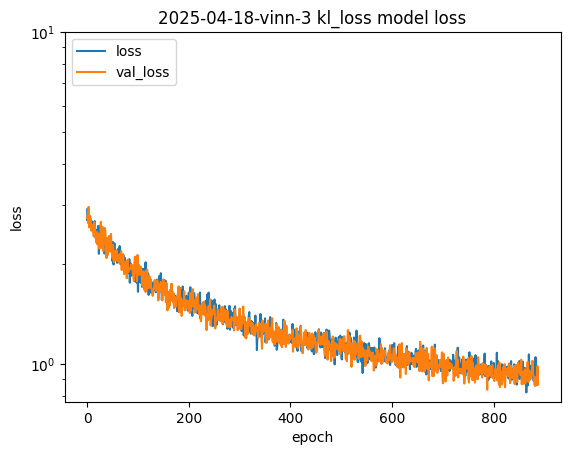

Val loss: 0.8343308568000793
Train loss: 0.9299868941307068


100%|██████████| 1024/1024 [01:45<00:00,  9.66it/s]


Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)
Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)


In [ ]:
EVAL_ONLY = False #@param{type:'boolean'}
res = tvim.train_variational_inference_model(params, eval_params, fileset, ISOSCAPE_SAVE_LOCATION, MODEL_SAVE_LOCATION, eval_only=EVAL_ONLY, enable_fraud_detection_eval=False)

In [ ]:
res

EvalResults(rmse={'mean_rmse': np.float64(1.0341350090453396), 'var_rmse': np.float64(1.02205492800969), 'per_radius_eval': []}, auc_scores={}, p_values_found={}, precision_targets_found={}, recall_targets_found={}, pr_curves={})

# Optional Rendering

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')

means_isoscape = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=0)
raster.animate(means_isoscape,  1, 1)

Driver: GTiff/GeoTIFF
Size is 1024 x 1024 x 2
Projection is GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
Origin = (-74.0000000000241, 5.29166666665704)
Pixel Size = (0.03828938802082461, -0.03812662760417103)
..

In [ ]:
vars_isoscape = raster.load_raster(ISOSCAPE_SAVE_LOCATION, use_only_band_index=1)
raster.animate(vars_isoscape,  1, 1)